In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [13]:
# Data augmentation with balanced and meaningful transformations for medical images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Minimal rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],  # Minimal brightness adjustments
    zoom_range=0.1,
    horizontal_flip=True,  # Allow horizontal flips (common in medical imaging)
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [14]:
# Train and test generators
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for ROC and AUC calculations
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# Load DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze all layers for fine-tuning


In [16]:
# Unfreeze only the last 10 layers for fine-tuning
for layer in base_model.layers[:-10]:  
    layer.trainable = False

In [17]:
# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=x)

In [18]:
# Compile the model with a very low learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# Address class imbalance by calculating class weights
class_weights = {0: len(train_generator.classes) / (2 * sum(train_generator.classes == 0)),
                 1: len(train_generator.classes) / (2 * sum(train_generator.classes == 1))}

In [20]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_DenseNet_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [21]:
# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/15


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.8115 - loss: 0.3895 - val_accuracy: 0.9022 - val_loss: 0.2650 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9327 - loss: 0.1643 - val_accuracy: 0.8798 - val_loss: 0.3244 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9485 - loss: 0.1155 - val_accuracy: 0.9087 - val_loss: 0.2698 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9606 - loss: 0.0997 - val_accuracy: 0.9151 - val_loss: 0.2641 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9663 - loss: 0.0805 - val_accuracy: 0.9231 - val_loss: 0.2809 - learning_rate: 1.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9695 - loss: 0.0845 - val_accuracy: 0.9087 - val_loss: 0.3392 - learning_rate: 1.0000e-04
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9739

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8786 - loss: 0.3803
Test Accuracy: 0.9151


In [23]:
# Predict the labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


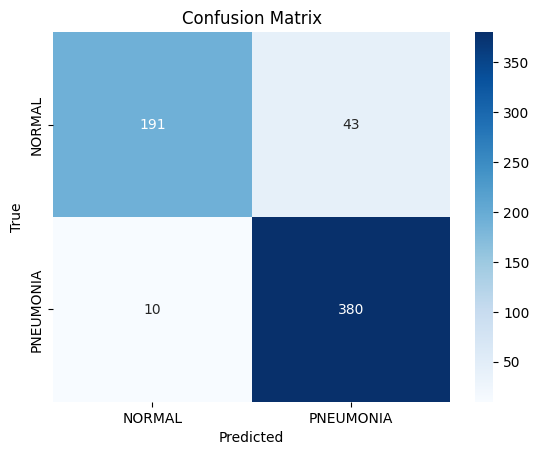

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       234
           1       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))

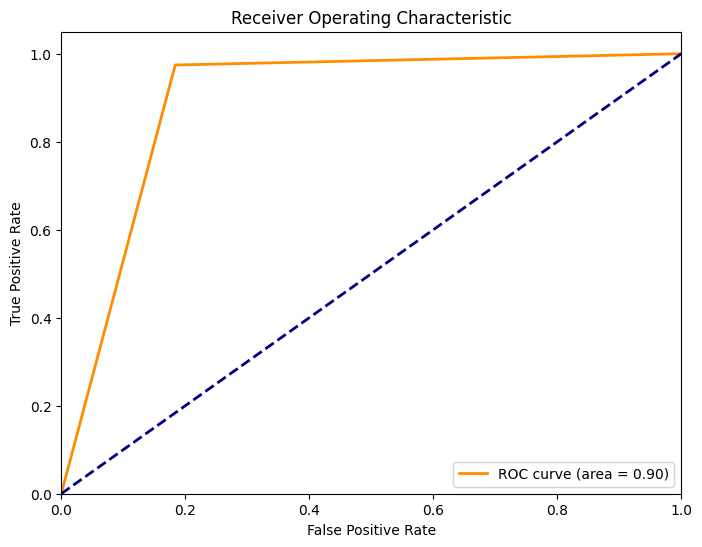

AUC Score: 0.8953


In [25]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# AUC Score
auc = roc_auc_score(y_true, y_pred)
print(f'AUC Score: {auc:.4f}')

# Load the saved model

In [26]:
# Define the test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(224, 224),  # Match the input size of DenseNet121
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Required for consistent evaluation metrics
)

Found 624 images belonging to 2 classes.


In [27]:
# Recreate the model architecture
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

In [28]:
# Build the model by providing an input shape
model.build(input_shape=(None, 224, 224, 3))

In [29]:
# Load the saved weights
model.load_weights('best_DenseNet_model.keras')

In [31]:
# Compile the model (needed for evaluation)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.4f}')

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8786 - loss: 0.3803
Test Accuracy: 0.9151


In [33]:
# Predict the labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step


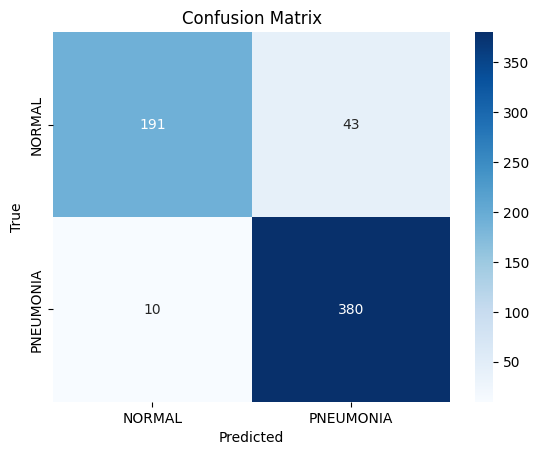

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
# Classification Report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.82      0.88       234
           1       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


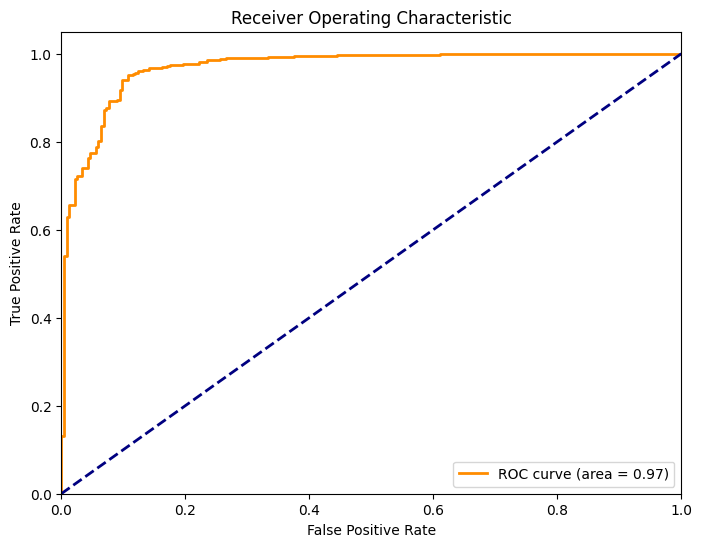

20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
AUC Score: 0.9687


In [36]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, model.predict(test_generator).ravel())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, model.predict(test_generator).ravel()))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# AUC Score
auc = roc_auc_score(y_true, model.predict(test_generator).ravel())
print(f'AUC Score: {auc:.4f}')